# Capacity analysis

## Introduction

Demo of the Capacity analysis.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload?

In [2]:
import datetime as dt
from openenergyid.capacity import CapacityInput, CapacityAnalysis
from openenergyid.capacity.models import CapacityOutput, PeakDetail
from openenergyid.models import TimeSeries


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## read in the sample data

In [3]:
with open("data/capacity/power_sample.json", "r") as f:
    # with open('data/capacity/electricity_delivered_sample.json', 'r') as f:

    input_data = CapacityInput.model_validate_json(f.read())

input_data.series.to_pandas(input_data.timezone)

2024-05-31 00:15:00+02:00    0.332
2024-05-31 00:30:00+02:00    0.292
2024-05-31 00:45:00+02:00    0.316
2024-05-31 01:00:00+02:00    0.316
2024-05-31 01:15:00+02:00    0.328
                             ...  
2024-07-02 22:45:00+02:00    1.184
2024-07-02 23:00:00+02:00    1.112
2024-07-02 23:15:00+02:00    1.056
2024-07-02 23:30:00+02:00    0.772
2024-07-02 23:45:00+02:00    0.732
Length: 3167, dtype: float64

## Analysis

First we make the analysis object
then run our functions find_peaks() and peaks_with_surroundings()
then export it to an output file

we also show an example of visualization for the analysis

In [4]:
analysis = CapacityAnalysis(
    data=input_data.series.to_pandas(timezone=input_data.timezone), threshold=0
)
peaks = analysis.find_peaks()
display(peaks)

2024-05-31 19:15:00+02:00    2.320
2024-06-13 17:30:00+02:00    3.596
2024-07-02 11:00:00+02:00    2.852
dtype: float64

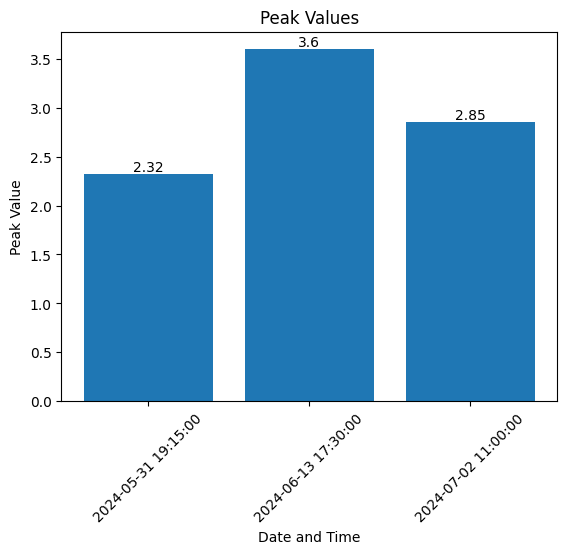

In [5]:
# Convert the index to a nicely formatted string representation
peaks.index = peaks.index.strftime("%Y-%m-%d %H:%M:%S")

# Plot the dataframe
bars = plt.bar(peaks.index, peaks)
plt.xlabel("Date and Time")
plt.ylabel("Peak Value")
plt.title("Peak Values")
plt.xticks(rotation=45)

# Adding the values to the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha="center", va="bottom")

plt.show()

## Peak moments


## Sliding frame analysis
![Pasted image 20240628161500.png](<attachment:Pasted image 20240628161500.png>)
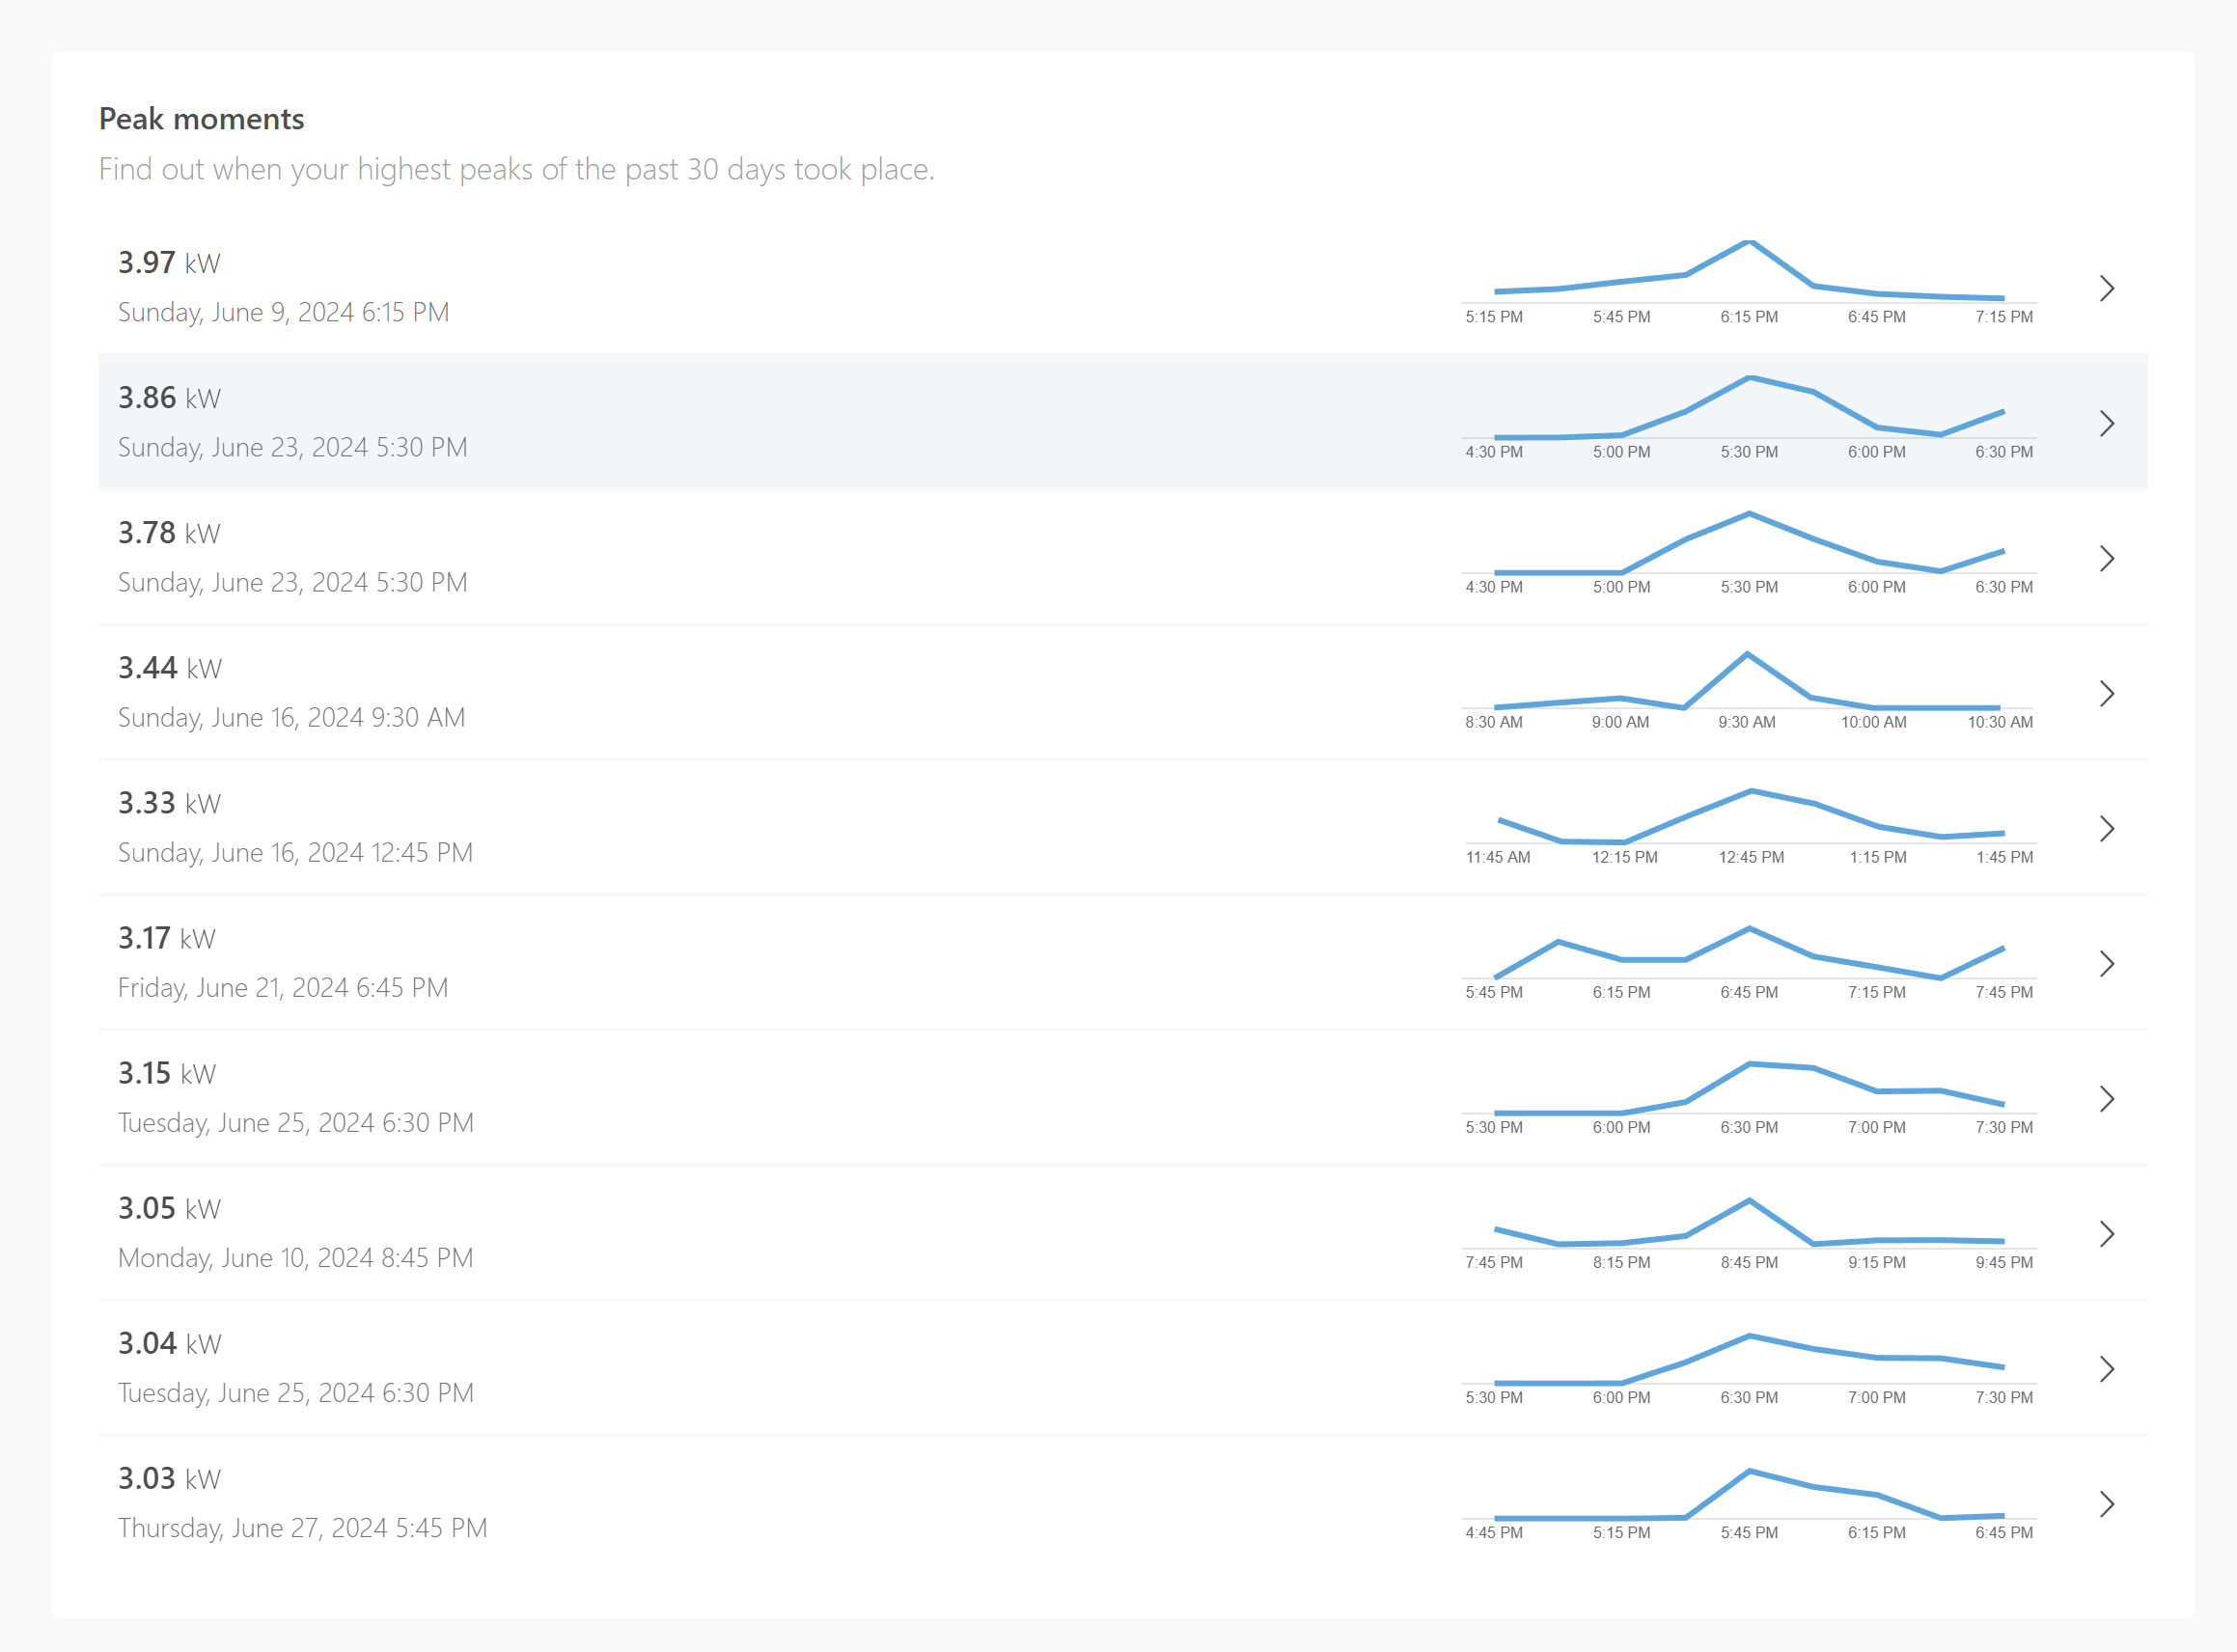

In [6]:
data = analysis.find_peaks_with_surroundings()
display(data)

[[Timestamp('2024-06-13 17:30:00+0200', tz='Europe/Brussels'),
  3.596,
  2024-06-13 16:30:00+02:00    2.104
  2024-06-13 16:45:00+02:00    0.900
  2024-06-13 17:00:00+02:00    2.628
  2024-06-13 17:15:00+02:00    1.352
  2024-06-13 17:30:00+02:00    3.596
  2024-06-13 17:45:00+02:00    3.316
  2024-06-13 18:00:00+02:00    2.216
  2024-06-13 18:15:00+02:00    1.412
  2024-06-13 18:30:00+02:00    0.768
  2024-06-13 18:45:00+02:00    0.544
  dtype: float64],
 [Timestamp('2024-06-24 18:00:00+0200', tz='Europe/Brussels'),
  3.048,
  2024-06-24 17:00:00+02:00    0.628
  2024-06-24 17:15:00+02:00    0.724
  2024-06-24 17:30:00+02:00    2.492
  2024-06-24 17:45:00+02:00    1.720
  2024-06-24 18:00:00+02:00    3.048
  2024-06-24 18:15:00+02:00    1.208
  2024-06-24 18:30:00+02:00    0.584
  2024-06-24 18:45:00+02:00    0.416
  2024-06-24 19:00:00+02:00    0.472
  2024-06-24 19:15:00+02:00    0.560
  dtype: float64],
 [Timestamp('2024-06-06 00:15:00+0200', tz='Europe/Brussels'),
  2.888,
  2024

In [7]:
# save output as our CapacityOutput object
output = CapacityOutput(
    peaks=TimeSeries.from_pandas(analysis.find_peaks()),
    peak_details=[
        PeakDetail(
            peak_time=peak_time,
            peak_value=peak_value,
            surrounding_data=TimeSeries.from_pandas(surrounding_data),
        )
        for peak_time, peak_value, surrounding_data in analysis.find_peaks_with_surroundings()
    ],
)

# save the CapacityOutput object to a file
with open("data/capacity/capacity_output.json", "w") as f:
    f.write(output.model_dump_json(indent=4))

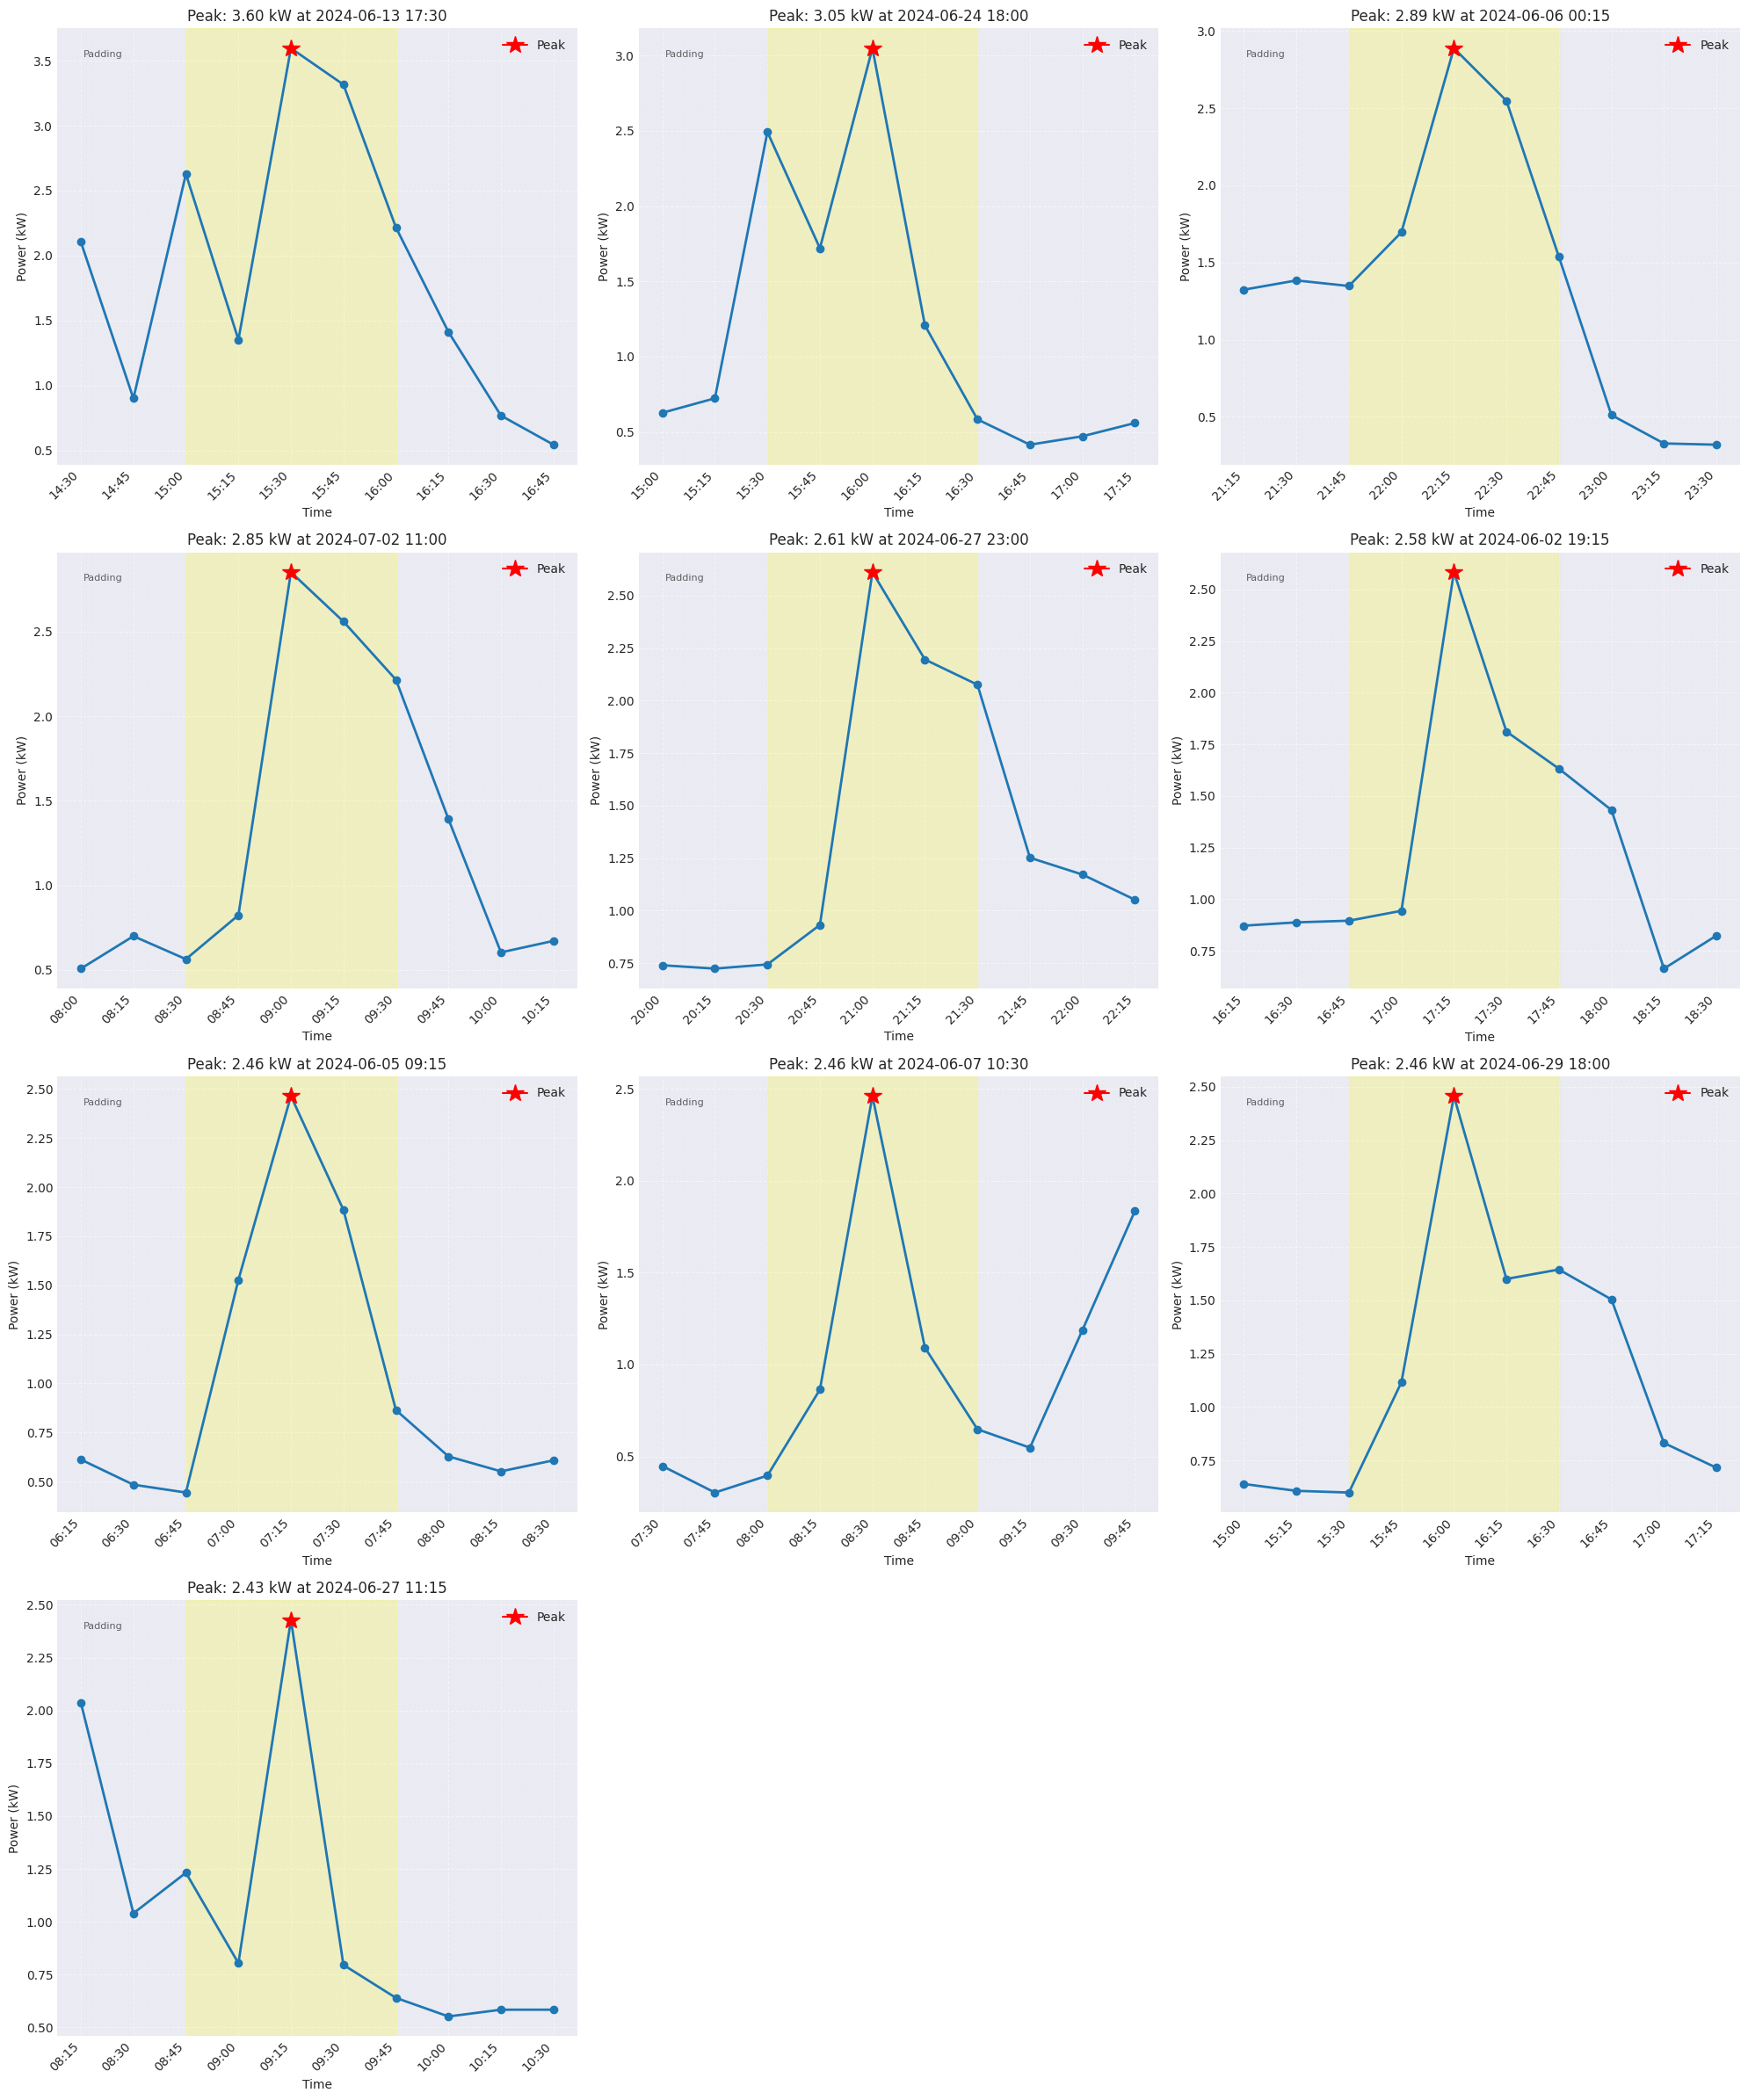

In [8]:
def plot_peaks(data):
    # Set up the plot style
    plt.style.use("seaborn-v0_8-dark")

    fig, axs = plt.subplots(4, 3, figsize=(20, 24))
    # fig.suptitle('Power Consumption Peaks', fontsize=16)

    axs = axs.flatten()

    for i, (peak_time, peak_value, surrounding_data) in enumerate(data):
        timestamps = surrounding_data.index
        values = surrounding_data.values

        ax = axs[i]
        ax.plot(timestamps, values, marker="o", linestyle="-", linewidth=2, markersize=6)
        ax.plot(peak_time, peak_value, marker="*", color="red", markersize=15, label="Peak")

        ax.set_title(f"Peak: {peak_value:.2f} kW at {peak_time.strftime('%Y-%m-%d %H:%M')}")
        ax.set_ylabel("Power (kW)")
        ax.set_xlabel("Time")

        # Set major locator for 15-minute intervals
        ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Set minor locator for every minute
        ax.xaxis.set_minor_locator(mdates.MinuteLocator())

        # Customize grid
        ax.grid(True, which="major", linestyle="--", alpha=0.5)
        ax.grid(True, which="minor", linestyle=":", alpha=0.2)

        # Rotate and align the tick labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        # Add legend
        ax.legend()

        # Highlight the padding area
        padding_minutes = 30  # Assuming 2 hours of padding (4 * 15 minutes on each side)
        start_padding = peak_time - dt.timedelta(minutes=padding_minutes)
        end_padding = peak_time + dt.timedelta(minutes=padding_minutes)
        ax.axvspan(start_padding, end_padding, color="yellow", alpha=0.2)

        # Add text to indicate padding
        ax.text(
            0.05,
            0.95,
            "Padding",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=8,
            alpha=0.7,
        )

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


plot_peaks(data)